# Pulsating Aurora

This notebook will run the ISR simulator with plasma state parameters that occur during pulsating aurora.  

## Import Stuff

Mainly import matplotlib, scipy and other packages for processing and plotting. Along with functions from the SimISR module.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
#SimISR packages
from SimISR import Path
from SimISR.utilFunctions import readconfigfile,makeconfigfile
from SimISR.runsim import main as runsim 
from SimISR.IonoContainer import IonoContainer,MakeTestIonoclass
from SimISR.analysisplots import analysisdump

## Input Parameter Set Up

The following cell will set up the pulsating aurora input plasma parameters. The model of the parameters will be Ne(1+ehn_lev*sin(2*pi*t/PT))

In [2]:
# Pulsating aurora parameters
PT=30.# the period of pulsation in seconds.
ehn_lev=2. # level of enhancement.
pa_range=[250.,300.]# range of pulsation along altitude in km

# set up the time and space vectors
dt=1.
timevec=sp.arange(120.)*dt
timemat=sp.column_stack((timevec,(timevec/dt+1)*dt))
z = (50.+sp.arange(120)*5.)
nz = len(z)
coords = sp.column_stack((sp.zeros((nz,2)),z))
# Create the weighting for the pulsation
logar=sp.logical_and((z>=pa_range[0]),(z<pa_range[1]))
PA_weight=1+.5*(ehn_lev-1)*(1-sp.cos(2.*sp.pi*timevec/PT))
PA_weight_rep = sp.tile(PA_weight[sp.newaxis,:],[logar.sum(),1])

# Make a set of input parameters with a electron density modeled by a Chapman function and an electron and ion temperature
# modeled as shifted and scalled atan functions.
Icont1=MakeTestIonoclass(testv=False,testtemp=True,N_0=1e11,z_0=250.0,H_0=50.0,coords=coords,times=timemat)
# Apply windowing to the electron density 
Icont1.Param_List[logar,:,-1,0]=PA_weight_rep*Icont1.Param_List[logar,:,-1,0]

# Create the starting point data for the fitter.
Icontstart = MakeTestIonoclass(testv=False,testtemp=False,N_0=1e11,z_0=250.0,H_0=50.0,
                               coords=coords,times =sp.array([[0,1e6]]))

## Set up for Simulation

Set up parameters for simulation like pulse length, pulse type, beam positions, etc. Also create a file structure to save the data at the different levels.

In [7]:
# Make file tree if not already inplace.
curloc = Path.cwd()
testpath = curloc.parent.joinpath('Testdata','PulsatingNotebook')
testpath.mkdir(exist_ok=True,parents=True)
# Read in default config file.
defaultpath = curloc.parent.joinpath('Test')
defcon = defaultpath.joinpath('statsbase.ini')
(sensdict,simparams) = readconfigfile(str(defcon))

# Adjust config file for specific case.
simparams['Beamlist']=[64016.0]
tint = 10.
ratio1 = tint/simparams['Tint']
simparams['Tint']=ratio1 * simparams['Tint']
simparams['Fitinter'] = ratio1 * simparams['Fitinter']
simparams['TimeLim'] = tint+timevec[-1]
# Save configuration file.
simparams['startfile']='startfile.h5'
makeconfigfile(str(testpath.joinpath('stats.ini')),simparams['Beamlist'],sensdict['Name'],simparams)
# Save out input plasma parameters
finalpath = testpath.joinpath('Origparams')
finalpath.mkdir(exist_ok=True,parents=True)
finalfile = finalpath.joinpath('0 stats.h5')
Icont1.saveh5(str(finalfile))
Icontstart.saveh5(str(testpath.joinpath('startfile.h5')))

## Run SimISR

In [11]:
functlist = ['spectrums','radardata','fitting']

config = str(testpath.joinpath('stats.ini'))

runsim(functlist,testpath,config,True,printlines=False)

Processing file 0 stats.h5 starting at 2017-01-20 17:59:14.339719



/Users/Bodangles/Documents/Python/SimISR/SimISR/specfunctions.py:39: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  outspecs = sp.zeros((N_x,N_t,npts))


Finished file 0 stats.h5 starting at 2017-01-20 17:59:59.854863

All spectrums created already

Data Now being created.
	Data from 0 of 1 being processed Name: 0.0 spectrum.h5.


/Users/Bodangles/anaconda/lib/python2.7/site-packages/numpy/lib/shape_base.py:873: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return c.reshape(shape_out)


		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making Beam 0 of 1
		 Making 

/Users/Bodangles/Documents/Python/SimISR/SimISR/specfunctions.py:135: RuntimeWarning: overflow encountered in exp
  grt0 = sp.exp(-datablock)
/Users/Bodangles/Documents/Python/ISRSpectrum/ISRSpectrum/ISRSpectrum.py:394: ComplexWarning: Casting complex values to real discards the imaginary part
  nuperp[-1] = nuei +nuee
/Users/Bodangles/Documents/Python/ISRSpectrum/ISRSpectrum/ISRSpectrum.py:395: ComplexWarning: Casting complex values to real discards the imaginary part
  nuparr[-1] = nuei
/Users/Bodangles/Documents/Python/ISRSpectrum/ISRSpectrum/ISRSpectrum.py:399: ComplexWarning: Casting complex values to real discards the imaginary part
  nuparr[si]=nuparr[si]+Bst[s][t]*Ni[ti]/sp.power(Ti[ti],1.5)
/Users/Bodangles/Documents/Python/ISRSpectrum/ISRSpectrum/ISRSpectrum.py:247: RuntimeWarning: overflow encountered in exp
  gord = (sp.sqrt(sp.pi)*sp.exp(-theta**2)-1j*2.0*scipy.special.dawsn(theta))/(K*C*sp.sqrt(2))
/Users/Bodangles/Documents/Python/ISRSpectrum/ISRSpectrum/ISRSpectrum.py:2

		Data for Location 155 of 156 fitted.


/Users/Bodangles/Documents/Python/SimISR/SimISR/specfunctions.py:172: RuntimeWarning: overflow encountered in double_scalars
  penadd = sp.sqrt(sp.power(sp.absolute(yout),2).sum())*pentsum.sum()
/Users/Bodangles/Documents/Python/ISRSpectrum/ISRSpectrum/ISRSpectrum.py:138: RuntimeWarning: overflow encountered in divide
  sig_i = (Ni/Ne)*(1j+omeg_i*igord)/(self.K**2*mu*h_e**2/qrot**2)


		Data for Location 155 of 156 fitted.


/Users/Bodangles/Documents/Python/SimISR/SimISR/specfunctions.py:151: RuntimeWarning: overflow encountered in divide
  guess_acf = guess_acf*rcs/guess_acf[0].real
/Users/Bodangles/Documents/Python/SimISR/SimISR/utilFunctions.py:121: RuntimeWarning: invalid value encountered in divide
  acf = acf/n


		Data for Location 155 of 156 fitted.
		Data for Location 155 of 156 fitted.


/Users/Bodangles/Documents/Python/ISRSpectrum/ISRSpectrum/ISRSpectrum.py:149: RuntimeWarning: overflow encountered in square
  inum = sp.absolute(sig_e)**2*nt_sum


		Data for Location 155 of 156 fitted.
		Data for Location 155 of 156 fitted.
		Data for Location 155 of 156 fitted.
		Data for Location 155 of 156 fitted.
		Data for Location 155 of 156 fitted.
		Data for Location 155 of 156 fitted.
		Data for Location 155 of 156 fitted.
		Data for Location 155 of 156 fitted.
		Data for Location 155 of 156 fitted.


False

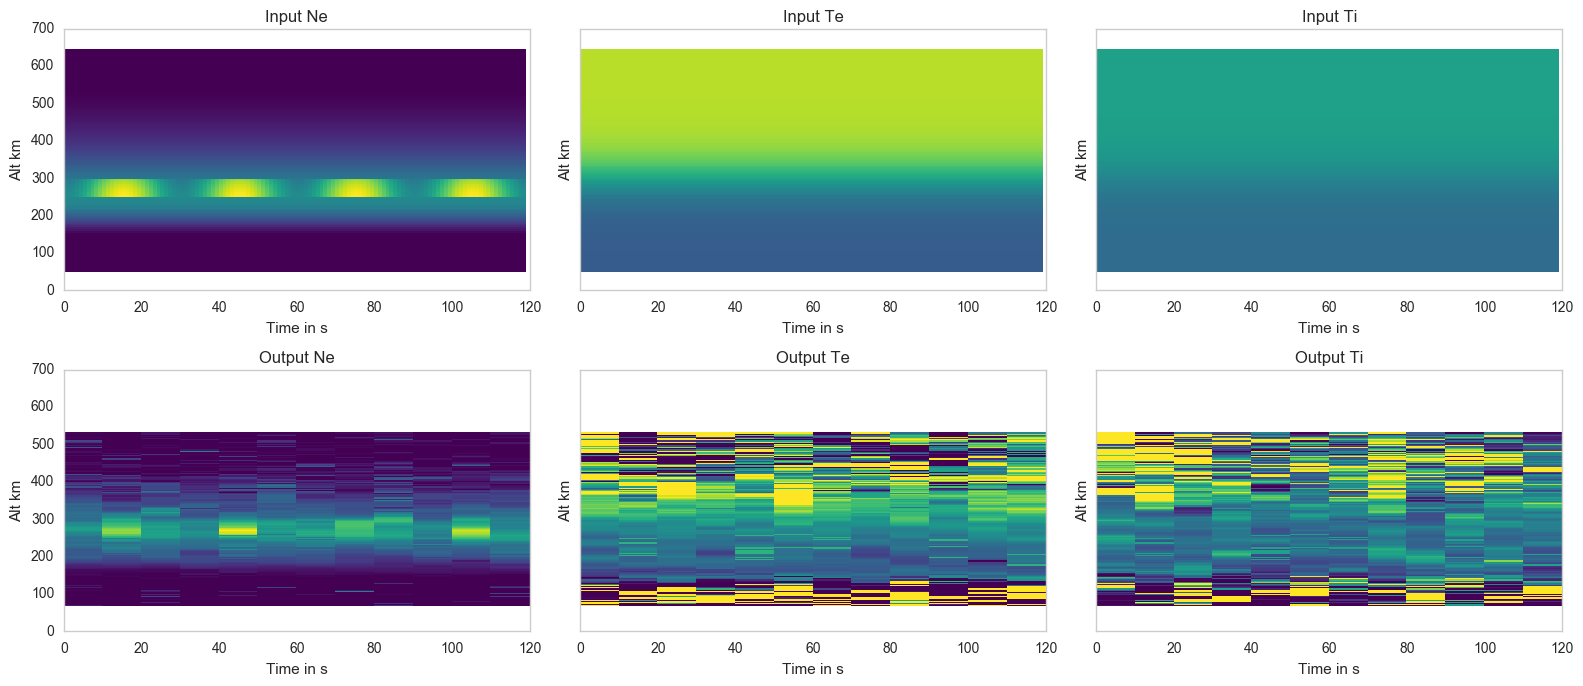

In [25]:
sns.set_style("whitegrid")
sns.set_context("notebook")
fig1,axmat =plt.subplots(2,3,figsize = (16,7),sharey=True)
axvec = axmat.flatten()
fittedfile =testpath.joinpath('Fitted','fitteddata.h5')
fitiono = IonoContainer.readh5(str(fittedfile))
paramlist = ['Ne','Te','Ti']
indlist =[sp.argwhere(ip==fitiono.Param_Names)[0][0] for ip in paramlist]
n_indlist =[sp.argwhere(('n'+ip)==fitiono.Param_Names)[0][0] for ip in paramlist]


Tmat_in, Amat_in =sp.meshgrid(timevec,z)
altin =Icont1.Cart_Coords[:,2]
tout=fitiono.Time_Vector[:,0]
altfit = fitiono.Cart_Coords[:,2]

Tmat_out, Amat_out =sp.meshgrid(tout,altfit)

in_ind=[[1,0],[1,1],[0,1]]
pbounds = [[1e10,2e11],[200.,3000.],[200.,2500.],[-100.,100.]]
for i in range(len(paramlist)):
    iax=axmat[0,i]
    iaxo=axmat[1,i]
    iinind = in_ind[i]
    ifitind = indlist[i]
    #plot input
    curin = Icont1.Param_List[:,:,iinind[0],iinind[1]]
    image_in = iax.pcolor(Tmat_in,Amat_in,curin,cmap='viridis',vmin=pbounds[i][0],vmax=pbounds[i][1])
    iax.set_xlabel("Time in s")
    iax.set_ylabel('Alt km')
    iax.set_title('Input ' +paramlist[i])
    #plot fitted data
    fitdata = fitiono.Param_List[:,:,ifitind].real
    image_out = iaxo.pcolor(Tmat_out,Amat_out,fitdata,cmap='viridis',vmin=pbounds[i][0],vmax=pbounds[i][1])
    iaxo.set_xlabel("Time in s")
    iaxo.set_ylabel('Alt km')
    iaxo.set_title('Output ' +paramlist[i])
    plt.tight_layout()